# Bias Analysis in Autocomplete Suggestions

This notebook demonstrates an end-to-end system for analyzing and mitigating bias in simulated search query autocompletions. The analysis covers data generation, NLP processing, bias quantification, and fairness-aware mitigation strategies.

## Project Overview

- **Objective**: Analyze and propose mitigation strategies for bias in search autocompletions
- **Data**: Synthetically generated to avoid scraping live endpoints
- **Methods**: NLP analysis, statistical testing, fairness-aware algorithms
- **Ethics**: All data is simulated; real deployment would require careful ethical review

## 1. Environment Setup and Imports

In [2]:
# Standard library imports
import sys
import os
import logging
from pathlib import Path

# Add src to path - fix path handling
notebook_dir = Path.cwd()
project_root = notebook_dir.parent
src_path = project_root / 'src'

# Add src directory to Python path
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

print(f"Notebook directory: {notebook_dir}")
print(f"Project root: {project_root}")
print(f"Source path: {src_path}")
print(f"Source path exists: {src_path.exists()}")

# Data processing imports
import pandas as pd
import numpy as np

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Test import before proceeding
try:
    from data_handler import AutocompleteDataGenerator, get_dataset_summary
    from analysis import AnalysisPipeline
    from mitigation import MitigationPipeline, MITIGATION_STRATEGIES
    print("✅ All custom modules imported successfully!")
except ImportError as e:
    print(f"❌ Import error: {e}")
    print("Available files in src directory:")
    if src_path.exists():
        for file in src_path.glob('*.py'):
            print(f"  - {file.name}")
    raise

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Environment setup completed successfully!")
print(f"Working directory: {os.getcwd()}")

Notebook directory: c:\Users\enisw\Documents\Projects\bias-autocomplete\notebooks
Project root: c:\Users\enisw\Documents\Projects\bias-autocomplete
Source path: c:\Users\enisw\Documents\Projects\bias-autocomplete\src
Source path exists: True


c:\Users\enisw\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\enisw\miniconda3\Lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\enisw\miniconda3\Lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


✅ All custom modules imported successfully!
Environment setup completed successfully!
Working directory: c:\Users\enisw\Documents\Projects\bias-autocomplete\notebooks


c:\Users\enisw\miniconda3\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


## 2. Data Generation

Generate synthetic autocomplete data with controllable bias parameters.

In [3]:
# Initialize data generator with reproducible seed
data_generator = AutocompleteDataGenerator(random_seed=42)

# Generate dataset with moderate bias
logger.info("Generating synthetic autocomplete dataset...")
dataset = data_generator.generate_full_dataset(
    num_base_queries=50,
    suggestions_per_query=8,
    bias_probability=0.4  # 40% chance of biased suggestions
)

# Display dataset overview
print(f"\nDataset Generated:")
print(f"- Total suggestions: {len(dataset)}")
print(f"- Unique base queries: {dataset['base_query'].nunique()}")
print(f"- Average suggestions per query: {len(dataset) / dataset['base_query'].nunique():.1f}")

# Show sample data
print("\nSample suggestions:")
sample_suggestions = dataset.groupby('base_query').head(3)[['base_query', 'suggestion']]
display(sample_suggestions.head(10))

2025-06-10 00:25:01,344 - INFO - Generating synthetic autocomplete dataset...
2025-06-10 00:25:01,344 - INFO - Generating full dataset with 50 queries, 8 suggestions each, bias_prob=0.4
2025-06-10 00:25:01,344 - INFO - Generating 50 base queries with seed 42
2025-06-10 00:25:01,344 - INFO - Generated 50 base queries
2025-06-10 00:25:01,348 - INFO - Generated dataset with 400 total suggestion records
2025-06-10 00:25:01,344 - INFO - Generating full dataset with 50 queries, 8 suggestions each, bias_prob=0.4
2025-06-10 00:25:01,344 - INFO - Generating 50 base queries with seed 42
2025-06-10 00:25:01,344 - INFO - Generated 50 base queries
2025-06-10 00:25:01,348 - INFO - Generated dataset with 400 total suggestion records



Dataset Generated:
- Total suggestions: 400
- Unique base queries: 31
- Average suggestions per query: 12.9

Sample suggestions:


,base_query,suggestion
0,developer,developer chef
1,developer,developer lawyer
2,developer,developer artist
8,doctor,doctor developer
9,doctor,doctor doctor
10,doctor,doctor manager
16,engineer,engineer chef
17,engineer,engineer lawyer
18,engineer,engineer developer
24,designer,designer teacher


In [4]:
# Save dataset for reproducibility
data_path = Path('../data/autocomplete_dataset.csv')
data_generator.save_dataset(dataset, str(data_path))

# Generate and display dataset summary
summary = get_dataset_summary(dataset)
print("Dataset Summary:")
for key, value in summary.items():
    if key != 'query_categories':
        print(f"- {key}: {value}")

print("\nTop query categories:")
query_counts = pd.Series(summary['query_categories']).head(10)
for query, count in query_counts.items():
    print(f"- '{query}': {count} suggestions")

2025-06-10 00:25:01,360 - INFO - Dataset saved to ..\data\autocomplete_dataset.csv
2025-06-10 00:25:01,362 - INFO - Dataset summary generated: 400 suggestions
2025-06-10 00:25:01,362 - INFO - Dataset summary generated: 400 suggestions


Dataset Summary:
- total_suggestions: 400
- unique_base_queries: 31
- avg_suggestions_per_query: 12.903225806451612
- generation_parameters: {'bias_probability': 0.4, 'random_seed': 42}

Top query categories:
- 'engineer': 32 suggestions
- 'teacher': 32 suggestions
- 'doctor': 32 suggestions
- 'designer': 24 suggestions
- 'scientist': 24 suggestions
- 'developer': 16 suggestions
- 'older adults in lawyer': 16 suggestions
- 'people of color in manager': 16 suggestions
- 'men in designer': 16 suggestions
- 'manager': 16 suggestions


## 3. Comprehensive NLP Analysis

Run the complete analysis pipeline including sentiment analysis, semantic similarity, and bias quantification.

In [5]:
# Initialize analysis pipeline
analysis_pipeline = AnalysisPipeline()

# Run comprehensive analysis
logger.info("Starting comprehensive NLP analysis...")
analysis_results, enriched_dataset = analysis_pipeline.analyze_dataset(dataset.copy())

print("\nAnalysis completed successfully!")
print(f"Enriched dataset shape: {enriched_dataset.shape}")
print(f"New columns added: {len(enriched_dataset.columns) - len(dataset.columns)}")

# Display the first few rows to verify sentiment columns and demographic indicators
display(enriched_dataset.head(10))

# Show the columns to confirm correct sentiment column naming
print("\nColumns in enriched_dataset:")
print(list(enriched_dataset.columns))

c:\Users\enisw\miniconda3\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model)


Analysis completed successfully!
Enriched dataset shape: (400, 21)
New columns added: 14


,query_id,base_query,suggestion_id,suggestion,generation_timestamp,bias_probability,random_seed,normalized_suggestion,suggestion_keywords,sentiment_dominant_sentiment,...,sentiment_POSITIVE,sentiment_NEGATIVE,sentiment_NEUTRAL,contains_male_terms,contains_female_terms,contains_technical_terms,contains_care_terms,contains_leadership_terms,gender_category,profession_category
0,0,developer,0,developer chef,2025-06-10T00:25:01.344546,0.4,42,developer chef,"[developer, chef]",NEUTRAL,...,0.217046,0.028387,0.754567,False,False,True,False,False,neutral,technical
1,0,developer,1,developer lawyer,2025-06-10T00:25:01.344546,0.4,42,developer lawyer,"[developer, lawyer]",NEUTRAL,...,0.201598,0.046962,0.751440,False,False,True,False,False,neutral,technical
2,0,developer,2,developer artist,2025-06-10T00:25:01.344546,0.4,42,developer artist,"[developer, artist]",NEUTRAL,...,0.215357,0.034609,0.750035,False,False,True,False,False,neutral,technical
3,0,developer,3,developer developer,2025-06-10T00:25:01.344546,0.4,42,developer developer,"[developer, developer]",NEUTRAL,...,0.326345,0.031392,0.642264,False,False,True,False,False,neutral,technical
4,0,developer,4,developer pilot,2025-06-10T00:25:01.344546,0.4,42,developer pilot,"[developer, pilot]",NEUTRAL,...,0.215080,0.058770,0.726150,False,False,True,False,False,neutral,technical
5,0,developer,5,developer nurse,2025-06-10T00:25:01.344546,0.4,42,developer nurse,"[developer, nurse]",NEUTRAL,...,0.237041,0.041422,0.721537,False,False,True,True,False,neutral,care
6,0,developer,6,developer teacher,2025-06-10T00:25:01.344546,0.4,42,developer teacher,"[developer, teacher]",NEUTRAL,...,0.258073,0.032384,0.709542,False,False,True,True,False,neutral,care
7,0,developer,7,developer designer,2025-06-10T00:25:01.344546,0.4,42,developer designer,"[developer, designer]",NEUTRAL,...,0.244058,0.038724,0.717218,False,False,True,False,False,neutral,technical
8,1,doctor,0,doctor developer,2025-06-10T00:25:01.344546,0.4,42,doctor developer,"[doctor, developer]",NEUTRAL,...,0.244664,0.064431,0.690905,False,False,True,False,False,neutral,technical
9,1,doctor,1,doctor doctor,2025-06-10T00:25:01.344546,0.4,42,doctor doctor,"[doctor, doctor]",NEUTRAL,...,0.244964,0.062666,0.692370,False,False,False,False,False,neutral,general



Columns in enriched_dataset:
['query_id', 'base_query', 'suggestion_id', 'suggestion', 'generation_timestamp', 'bias_probability', 'random_seed', 'normalized_suggestion', 'suggestion_keywords', 'sentiment_dominant_sentiment', 'sentiment_confidence', 'sentiment_POSITIVE', 'sentiment_NEGATIVE', 'sentiment_NEUTRAL', 'contains_male_terms', 'contains_female_terms', 'contains_technical_terms', 'contains_care_terms', 'contains_leadership_terms', 'gender_category', 'profession_category']


### 3.1 Sentiment Analysis Results

Sentiment Analysis Results:
- Average confidence: 0.770

Sentiment distribution:
- NEUTRAL: 397 suggestions (99.2%)
- POSITIVE: 3 suggestions (0.8%)


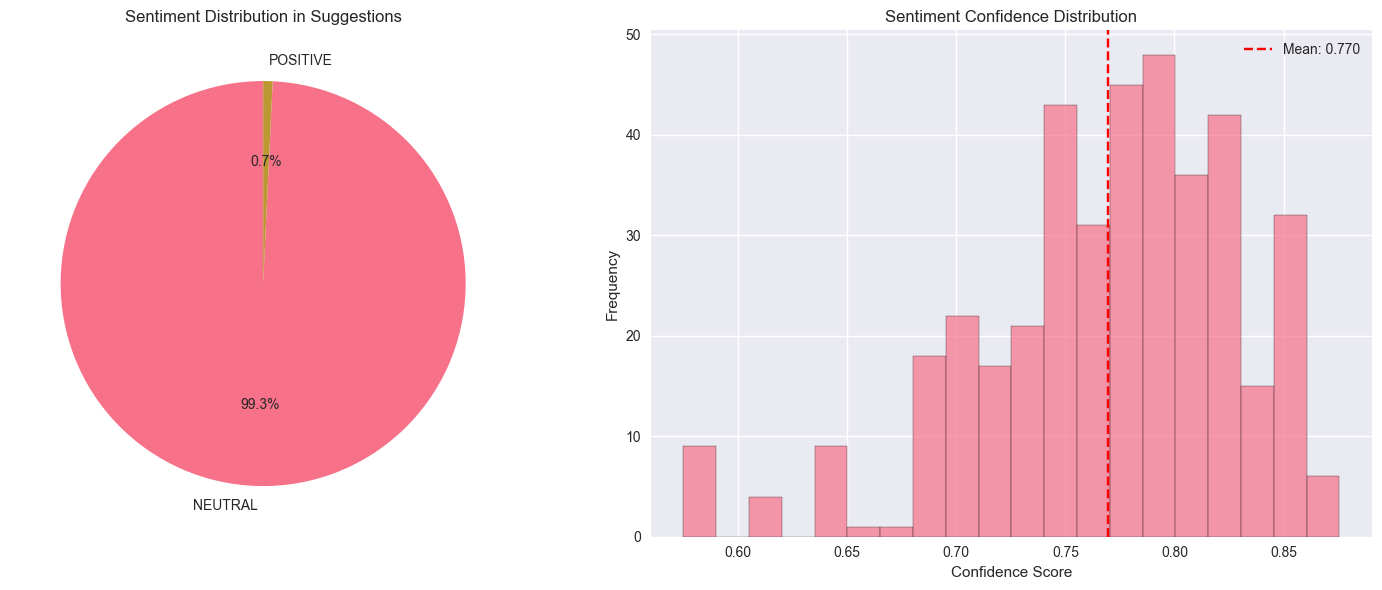

In [6]:
# Display sentiment analysis results
sentiment_results = analysis_results['sentiment_analysis']
print("Sentiment Analysis Results:")
print(f"- Average confidence: {sentiment_results['average_confidence']:.3f}")
print("\nSentiment distribution:")
for sentiment, count in sentiment_results['sentiment_distribution'].items():
    percentage = (count / len(enriched_dataset)) * 100
    print(f"- {sentiment}: {count} suggestions ({percentage:.1f}%)")

# Visualize sentiment distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Sentiment distribution pie chart
sentiment_counts = pd.Series(sentiment_results['sentiment_distribution'])
ax1.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
ax1.set_title('Sentiment Distribution in Suggestions')

# Confidence distribution histogram
ax2.hist(enriched_dataset['sentiment_confidence'], bins=20, alpha=0.7, edgecolor='black')
ax2.set_xlabel('Confidence Score')
ax2.set_ylabel('Frequency')
ax2.set_title('Sentiment Confidence Distribution')
ax2.axvline(sentiment_results['average_confidence'], color='red', linestyle='--', 
           label=f'Mean: {sentiment_results["average_confidence"]:.3f}')
ax2.legend()

plt.tight_layout()
plt.show()

### 3.2 Bias Quantification Results

In [7]:
# Display bias quantification results
bias_results = analysis_results['bias_quantification']

print("=== GENDER REPRESENTATION BIAS ===")
gender_bias = bias_results['gender_representation_bias']
print(f"Chi-square test p-value: {gender_bias['chi_square_test']['p_value']:.6f}")
print(f"Significant bias detected: {gender_bias['chi_square_test']['significant']}")
print("\nGender category distribution:")
for category, count in gender_bias['category_counts'].items():
    proportion = gender_bias['category_proportions'][category]
    ratio = gender_bias['representation_ratio'][category]
    print(f"- {category}: {count} suggestions ({proportion:.1%}) [ratio: {ratio:.2f}]")

print("\n=== PROFESSION REPRESENTATION BIAS ===")
profession_bias = bias_results['profession_representation_bias']
print(f"Chi-square test p-value: {profession_bias['chi_square_test']['p_value']:.6f}")
print(f"Significant bias detected: {profession_bias['chi_square_test']['significant']}")
print("\nProfession category distribution:")
for category, count in profession_bias['category_counts'].items():
    proportion = profession_bias['category_proportions'][category]
    ratio = profession_bias['representation_ratio'][category]
    print(f"- {category}: {count} suggestions ({proportion:.1%}) [ratio: {ratio:.2f}]")

=== GENDER REPRESENTATION BIAS ===
Chi-square test p-value: 0.000000
Significant bias detected: True

Gender category distribution:
- neutral: 282 suggestions (70.5%) [ratio: 2.12]
- male: 86 suggestions (21.5%) [ratio: 0.65]
- female: 32 suggestions (8.0%) [ratio: 0.24]

=== PROFESSION REPRESENTATION BIAS ===
Chi-square test p-value: 0.000000
Significant bias detected: True

Profession category distribution:
- general: 157 suggestions (39.2%) [ratio: 1.57]
- technical: 97 suggestions (24.2%) [ratio: 0.97]
- care: 90 suggestions (22.5%) [ratio: 0.90]
- leadership: 56 suggestions (14.0%) [ratio: 0.56]


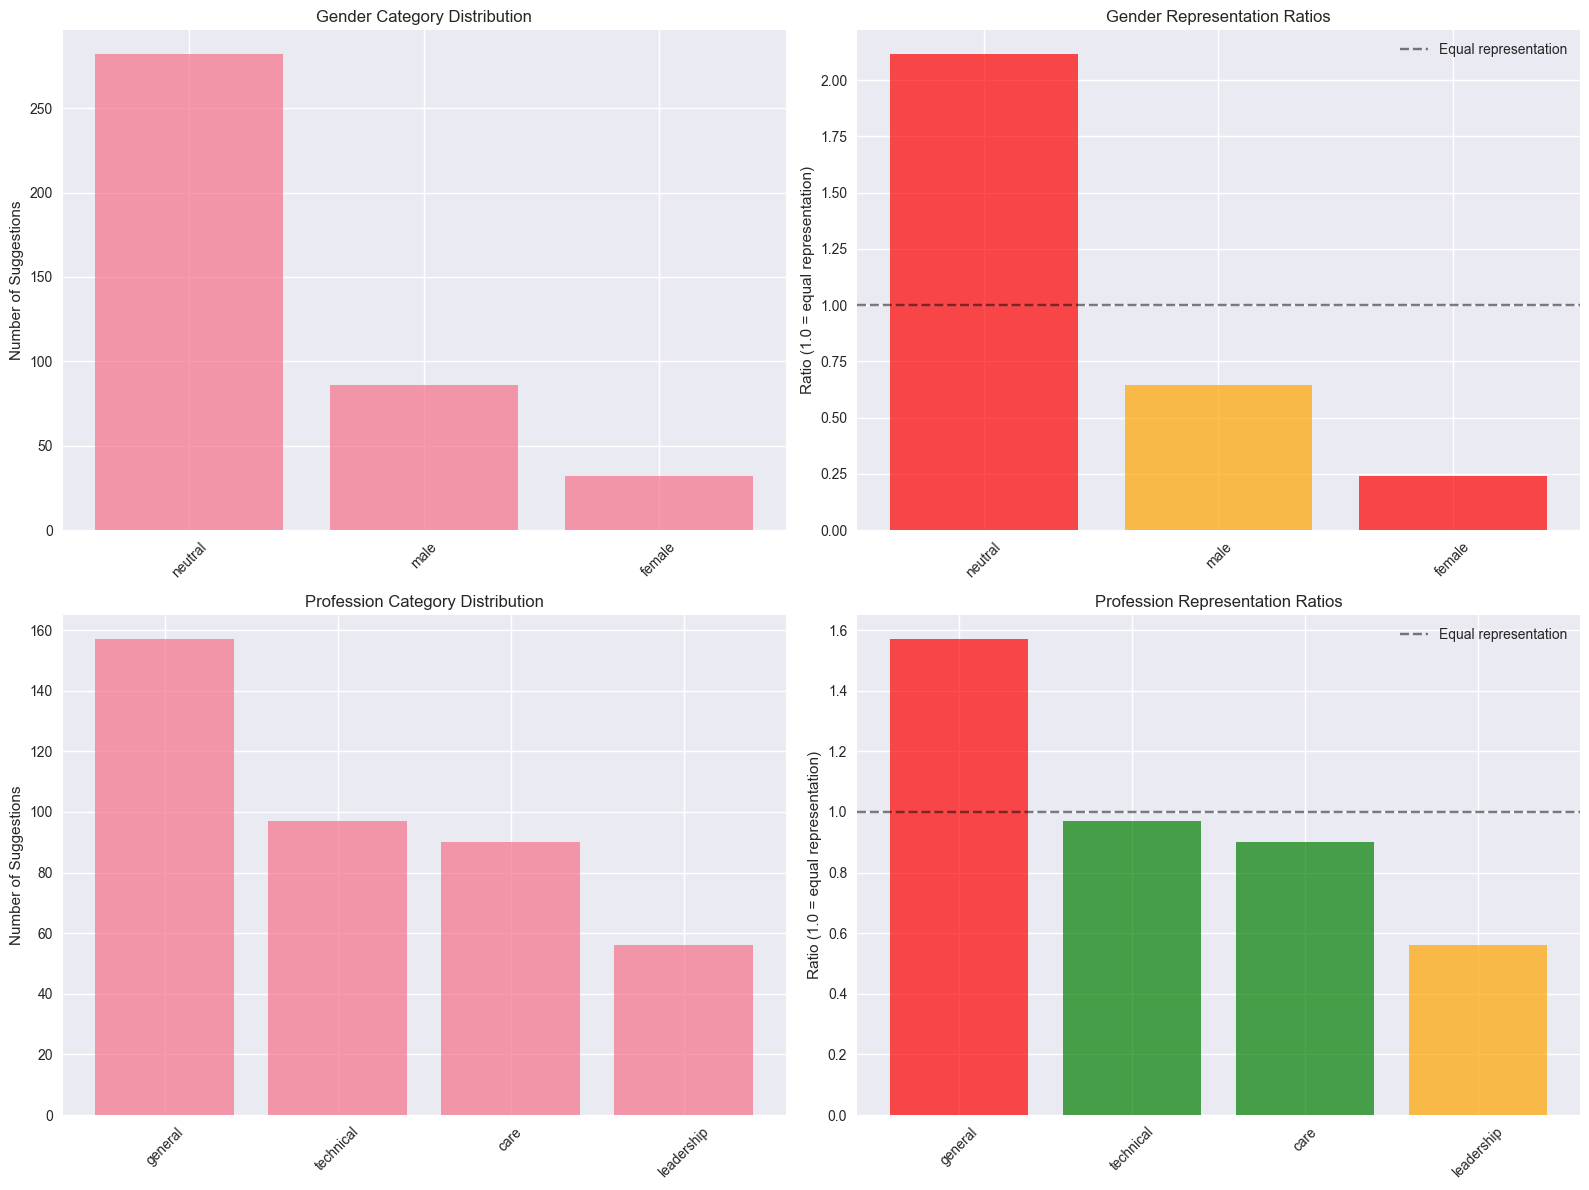

In [8]:
# Visualize bias analysis results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Gender representation
gender_counts = pd.Series(gender_bias['category_counts'])
ax1.bar(gender_counts.index, gender_counts.values, alpha=0.7)
ax1.set_title('Gender Category Distribution')
ax1.set_ylabel('Number of Suggestions')
ax1.tick_params(axis='x', rotation=45)

# Gender representation ratios
gender_ratios = pd.Series(gender_bias['representation_ratio'])
colors = ['green' if r < 1.2 and r > 0.8 else 'orange' if r < 1.5 and r > 0.5 else 'red' for r in gender_ratios.values]
ax2.bar(gender_ratios.index, gender_ratios.values, color=colors, alpha=0.7)
ax2.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Equal representation')
ax2.set_title('Gender Representation Ratios')
ax2.set_ylabel('Ratio (1.0 = equal representation)')
ax2.tick_params(axis='x', rotation=45)
ax2.legend()

# Profession representation
profession_counts = pd.Series(profession_bias['category_counts'])
ax3.bar(profession_counts.index, profession_counts.values, alpha=0.7)
ax3.set_title('Profession Category Distribution')
ax3.set_ylabel('Number of Suggestions')
ax3.tick_params(axis='x', rotation=45)

# Profession representation ratios
profession_ratios = pd.Series(profession_bias['representation_ratio'])
colors = ['green' if r < 1.2 and r > 0.8 else 'orange' if r < 1.5 and r > 0.5 else 'red' for r in profession_ratios.values]
ax4.bar(profession_ratios.index, profession_ratios.values, color=colors, alpha=0.7)
ax4.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Equal representation')
ax4.set_title('Profession Representation Ratios')
ax4.set_ylabel('Ratio (1.0 = equal representation)')
ax4.tick_params(axis='x', rotation=45)
ax4.legend()

plt.tight_layout()
plt.show()

### 3.3 Sentiment Bias Analysis

=== SENTIMENT BIAS BY GENDER ===
Group statistics:

NEUTRAL group:
  - Mean sentiment: 0.167
  - Standard deviation: 0.058
  - Count: 282
  - Positive ratio: 0.000
  - Negative ratio: 0.000

MALE group:
  - Mean sentiment: 0.134
  - Standard deviation: 0.052
  - Count: 86
  - Positive ratio: 0.000
  - Negative ratio: 0.000

FEMALE group:
  - Mean sentiment: 0.273
  - Standard deviation: 0.156
  - Count: 32
  - Positive ratio: 0.094
  - Negative ratio: 0.000

Pairwise statistical tests:
- neutral_vs_male: p-value = 0.000004, significant = True
- neutral_vs_female: p-value = 0.000000, significant = True
- male_vs_female: p-value = 0.000000, significant = True


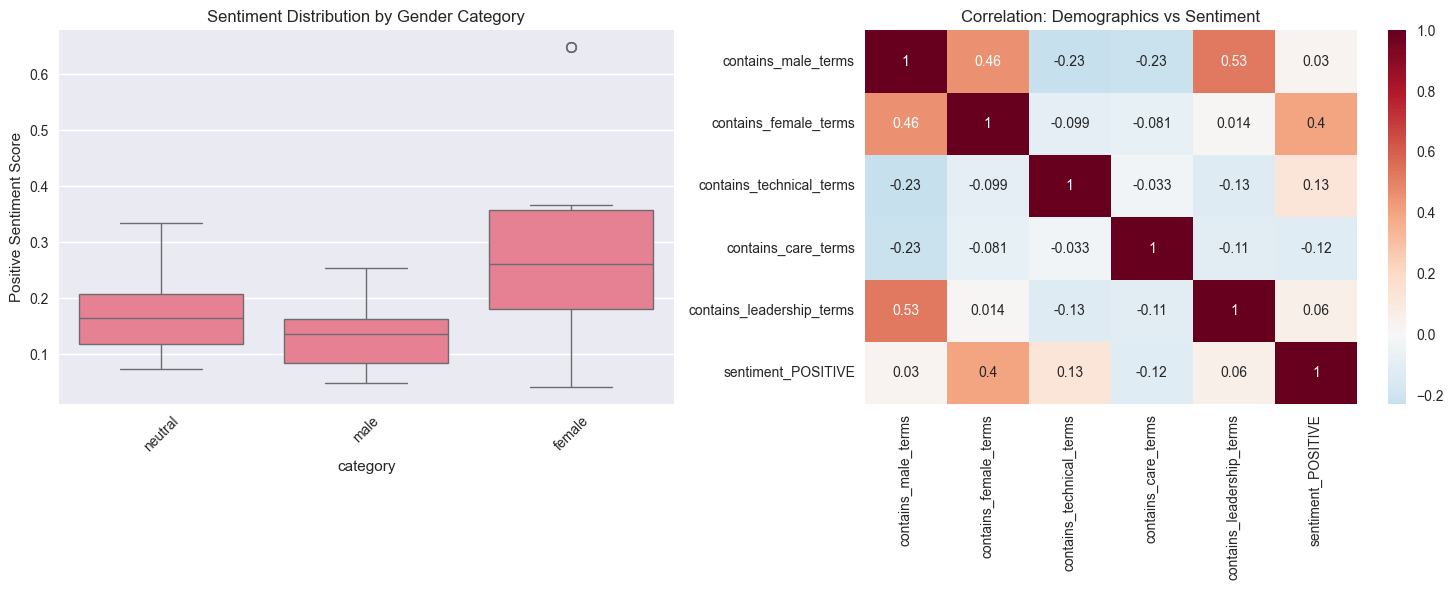

In [9]:
# Analyze sentiment bias by gender category
if 'sentiment_bias_by_gender' in bias_results:
    sentiment_bias = bias_results['sentiment_bias_by_gender']
    
    print("=== SENTIMENT BIAS BY GENDER ===")
    print("Group statistics:")
    for group, stats in sentiment_bias['group_statistics'].items():
        print(f"\n{group.upper()} group:")
        print(f"  - Mean sentiment: {stats['mean_sentiment']:.3f}")
        print(f"  - Standard deviation: {stats['std_sentiment']:.3f}")
        print(f"  - Count: {stats['count']}")
        print(f"  - Positive ratio: {stats['positive_ratio']:.3f}")
        print(f"  - Negative ratio: {stats['negative_ratio']:.3f}")
    
    # Statistical tests
    if 'pairwise_tests' in sentiment_bias:
        print("\nPairwise statistical tests:")
        for comparison, test_result in sentiment_bias['pairwise_tests'].items():
            print(f"- {comparison}: p-value = {test_result['p_value']:.6f}, significant = {test_result['significant']}")

# Visualize sentiment by gender categories
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Box plot of sentiment scores by gender category
gender_sentiment_data = []
for category in enriched_dataset['gender_category'].unique():
    category_data = enriched_dataset[enriched_dataset['gender_category'] == category]
    if 'sentiment_POSITIVE' in category_data.columns:
        sentiment_scores = category_data['sentiment_POSITIVE'].dropna()
        for score in sentiment_scores:
            gender_sentiment_data.append({'category': category, 'sentiment': score})

if gender_sentiment_data:
    sentiment_df = pd.DataFrame(gender_sentiment_data)
    sns.boxplot(data=sentiment_df, x='category', y='sentiment', ax=ax1)
    ax1.set_title('Sentiment Distribution by Gender Category')
    ax1.set_ylabel('Positive Sentiment Score')
    ax1.tick_params(axis='x', rotation=45)

# Sentiment vs demographic indicators heatmap
demo_columns = ['contains_male_terms', 'contains_female_terms', 'contains_technical_terms', 
               'contains_care_terms', 'contains_leadership_terms']
if all(col in enriched_dataset.columns for col in demo_columns) and 'sentiment_POSITIVE' in enriched_dataset.columns:
    corr_matrix = enriched_dataset[demo_columns + ['sentiment_POSITIVE']].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, ax=ax2)
    ax2.set_title('Correlation: Demographics vs Sentiment')

plt.tight_layout()
plt.show()

## 4. Bias Mitigation Strategies

Implement and evaluate fairness-aware re-ranking and filtering approaches.

In [10]:
# Display available mitigation strategies
print("Available Mitigation Strategies:")
print("=" * 50)

for strategy_name, strategy_info in MITIGATION_STRATEGIES.items():
    print(f"\n{strategy_name.upper()}")
    print(f"Description: {strategy_info['description']}")
    print(f"Algorithm: {strategy_info['algorithm']}")
    print(f"Parameters: {', '.join(strategy_info['parameters'])}")
    print(f"Strengths: {', '.join(strategy_info['strengths'])}")
    print(f"Limitations: {', '.join(strategy_info['limitations'])}")

Available Mitigation Strategies:

FAIRNESS_AWARE_RERANKING
Description: Re-ranks suggestions based on combined fairness and relevance scores
Algorithm: combined_score = (1-α) * relevance_score + α * fairness_score
Parameters: fairness_weight (α)
Strengths: Balances fairness and utility, Transparent scoring, Configurable trade-offs
Limitations: Requires good fairness metrics, May reduce relevance, Computational overhead

BIAS_FILTERING
Description: Filters out suggestions that fail fairness criteria
Algorithm: filter(suggestion) = fairness_score > threshold AND not in banned_patterns
Parameters: strictness_threshold, banned_patterns
Strengths: Hard constraints on bias, Interpretable rules, Fast execution
Limitations: May over-filter, Rule-based limitations, Requires pattern updates

DEMOGRAPHIC_BALANCING
Description: Ensures balanced representation across demographic groups
Algorithm: Quota-based selection ensuring proportional representation
Parameters: target_proportions, minimum_thre

### 4.1 Fairness-Aware Re-ranking Demonstration

In [11]:
# Select a sample query for demonstration
sample_query = "women in"
sample_suggestions = dataset[dataset['base_query'].str.contains(sample_query, case=False)]['suggestion'].unique()[:10]

print(f"Demonstrating mitigation for query: '{sample_query}'")
print(f"Original suggestions ({len(sample_suggestions)}):")
for i, suggestion in enumerate(sample_suggestions, 1):
    print(f"  {i}. {suggestion}")

# Initialize mitigation pipeline with different fairness weights
fairness_weights = [0.1, 0.3, 0.5, 0.7]
mitigation_results = {}

for weight in fairness_weights:
    print(f"\n{'='*60}")
    print(f"MITIGATION WITH FAIRNESS WEIGHT = {weight}")
    print(f"{'='*60}")
    
    # Initialize pipeline
    mitigation_pipeline = MitigationPipeline(
        fairness_weight=weight,
        filter_strictness=0.4
    )
    
    # Apply mitigation
    results = mitigation_pipeline.mitigate_bias(
        list(sample_suggestions),
        sample_query,
        max_suggestions=8
    )
    
    mitigation_results[weight] = results
    
    # Display results
    print(f"\nMitigated suggestions ({len(results['mitigated_suggestions'])}):")
    for i, suggestion in enumerate(results['mitigated_suggestions'], 1):
        # Find corresponding score
        score_info = next((s for s in results['suggestion_scores'] if s['suggestion'] == suggestion), None)
        if score_info:
            combined_score = score_info['combined_score']
            relevance = score_info['score_breakdown']['relevance_score']
            fairness = score_info['score_breakdown']['fairness_score']
            print(f"  {i}. {suggestion}")
            print(f"     [Combined: {combined_score:.3f}, Relevance: {relevance:.3f}, Fairness: {fairness:.3f}]")
    
    # Display rejected suggestions
    if results['rejected_suggestions']:
        print(f"\nRejected suggestions ({len(results['rejected_suggestions'])}):")
        for suggestion, reason in results['rejected_suggestions']:
            print(f"  - '{suggestion}': {reason}")
    
    # Display pipeline statistics
    stats = results['pipeline_stats']
    print(f"\nPipeline Statistics:")
    print(f"  - Original count: {stats['original_count']}")
    print(f"  - Final count: {stats['final_count']}")
    print(f"  - Rejection rate: {stats['rejection_rate']:.1%}")

2025-06-10 00:25:15,639 - INFO - Starting bias mitigation pipeline for query: 'women in'
2025-06-10 00:25:15,640 - INFO - Re-ranking 10 suggestions with fairness_weight=0.1
2025-06-10 00:25:15,640 - INFO - Re-ranking completed. Top suggestion: 'women in STEM' with score 0.869
2025-06-10 00:25:15,641 - INFO - Filtered 0 suggestions, kept 10
2025-06-10 00:25:15,641 - INFO - Mitigation completed: 8 final suggestions
2025-06-10 00:25:15,642 - INFO - Starting bias mitigation pipeline for query: 'women in'
2025-06-10 00:25:15,643 - INFO - Re-ranking 10 suggestions with fairness_weight=0.3
2025-06-10 00:25:15,643 - INFO - Re-ranking completed. Top suggestion: 'women in engineering' with score 0.826
2025-06-10 00:25:15,643 - INFO - Filtered 0 suggestions, kept 10
2025-06-10 00:25:15,644 - INFO - Mitigation completed: 8 final suggestions
2025-06-10 00:25:15,644 - INFO - Starting bias mitigation pipeline for query: 'women in'
2025-06-10 00:25:15,645 - INFO - Re-ranking 10 suggestions with fairne

Demonstrating mitigation for query: 'women in'
Original suggestions (10):
  1. women in engineering
  2. women in STEM
  3. women in medicine
  4. women in technology
  5. women in leadership
  6. women in nurse scientist
  7. women in nurse engineer
  8. women in nurse pilot
  9. women in fashion
  10. women in teaching

MITIGATION WITH FAIRNESS WEIGHT = 0.1

Mitigated suggestions (8):
  1. women in STEM
     [Combined: 0.869, Relevance: 0.892, Fairness: 0.657]
  2. women in fashion
     [Combined: 0.847, Relevance: 0.870, Fairness: 0.632]
  3. women in medicine
     [Combined: 0.844, Relevance: 0.865, Fairness: 0.657]
  4. women in teaching
     [Combined: 0.844, Relevance: 0.865, Fairness: 0.657]
  5. women in engineering
     [Combined: 0.843, Relevance: 0.852, Fairness: 0.765]
  6. women in technology
     [Combined: 0.836, Relevance: 0.856, Fairness: 0.657]
  7. women in leadership
     [Combined: 0.833, Relevance: 0.856, Fairness: 0.632]
  8. women in nurse pilot
     [Combined:

### 4.2 Mitigation Effectiveness Analysis

Mitigation Effectiveness Summary:


,fairness_weight,final_count,rejection_rate,avg_combined_score,avg_relevance_score,avg_fairness_score
0,0.1,8,0.0,0.831,0.850,0.662
1,0.3,8,0.0,0.795,0.849,0.668
2,0.5,8,0.0,0.758,0.849,0.668
3,0.7,8,0.0,0.722,0.849,0.668


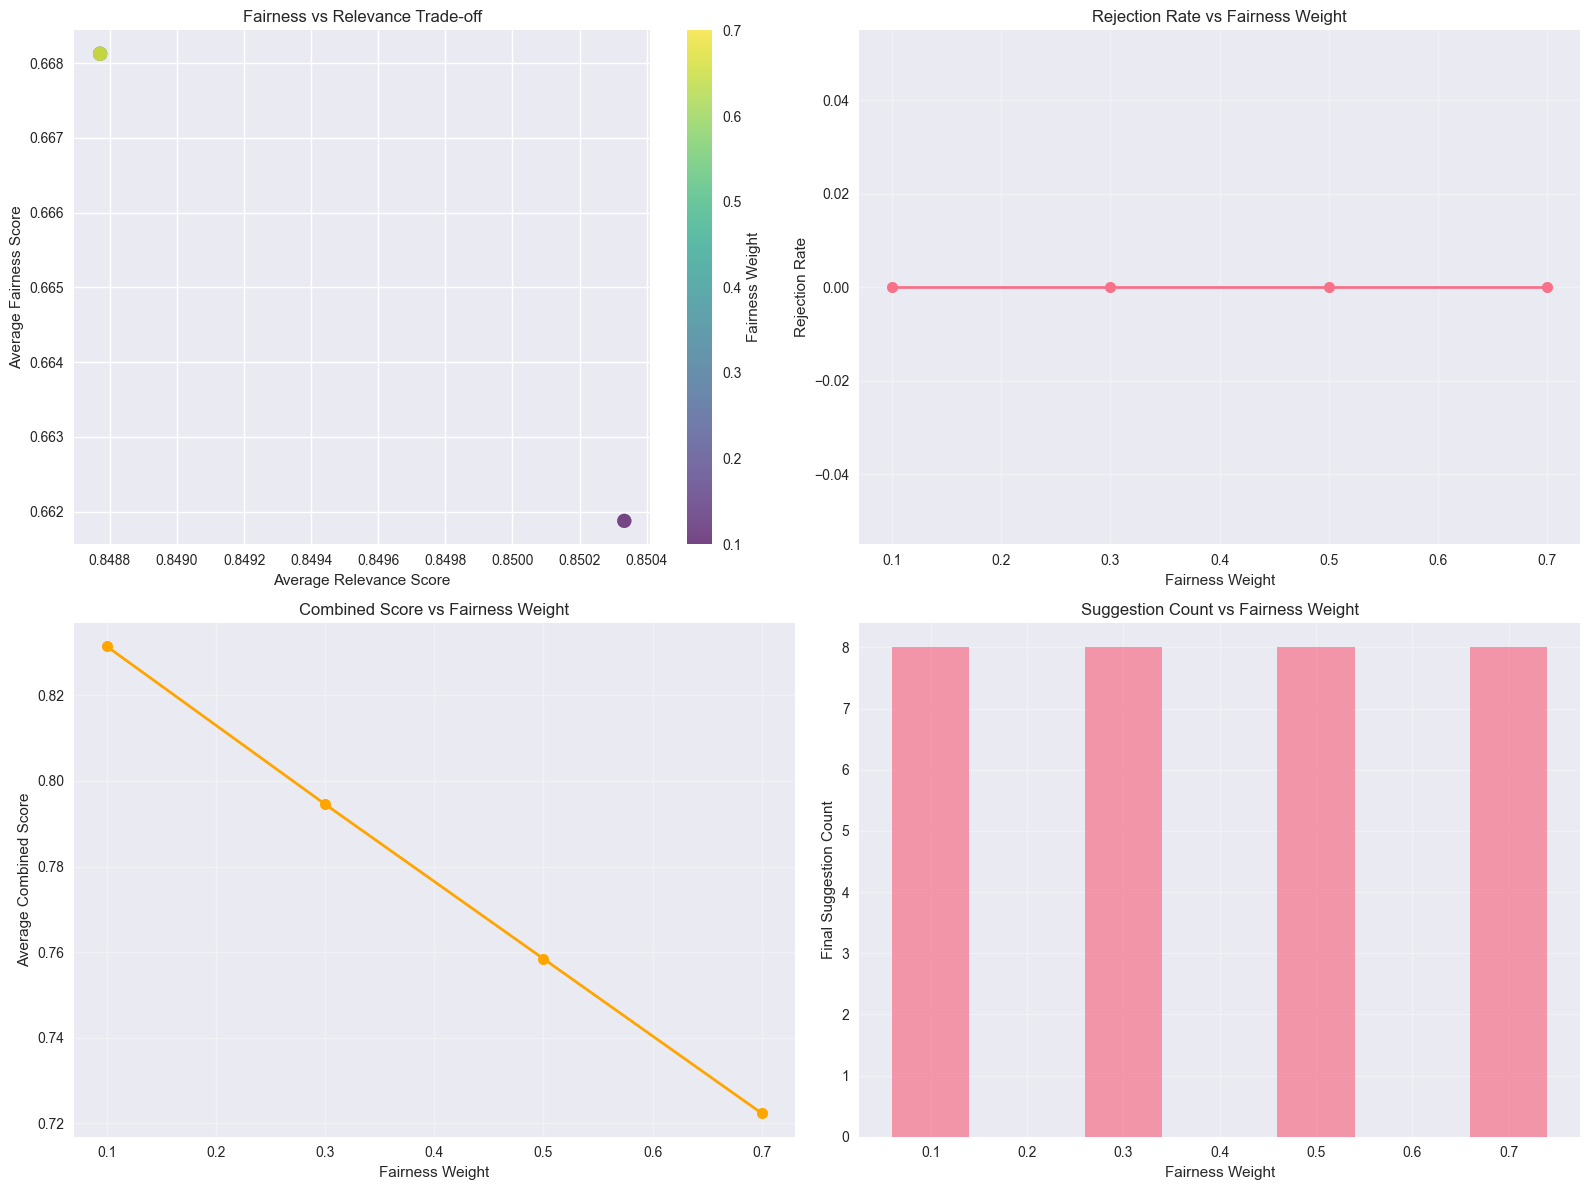

In [12]:
# Analyze the effectiveness of different fairness weights
effectiveness_data = []

for weight, results in mitigation_results.items():
    stats = results['pipeline_stats']
    
    # Calculate average scores
    if results['suggestion_scores']:
        avg_combined = np.mean([s['combined_score'] for s in results['suggestion_scores']])
        avg_relevance = np.mean([s['score_breakdown']['relevance_score'] for s in results['suggestion_scores']])
        avg_fairness = np.mean([s['score_breakdown']['fairness_score'] for s in results['suggestion_scores']])
    else:
        avg_combined = avg_relevance = avg_fairness = 0
    
    effectiveness_data.append({
        'fairness_weight': weight,
        'final_count': stats['final_count'],
        'rejection_rate': stats['rejection_rate'],
        'avg_combined_score': avg_combined,
        'avg_relevance_score': avg_relevance,
        'avg_fairness_score': avg_fairness
    })

effectiveness_df = pd.DataFrame(effectiveness_data)

# Display effectiveness summary
print("Mitigation Effectiveness Summary:")
print("=" * 80)
display(effectiveness_df.round(3))

# Visualize effectiveness trade-offs
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Fairness vs Relevance trade-off
ax1.scatter(effectiveness_df['avg_relevance_score'], effectiveness_df['avg_fairness_score'], 
           s=100, c=effectiveness_df['fairness_weight'], cmap='viridis', alpha=0.7)
ax1.set_xlabel('Average Relevance Score')
ax1.set_ylabel('Average Fairness Score')
ax1.set_title('Fairness vs Relevance Trade-off')
colorbar1 = plt.colorbar(ax1.collections[0], ax=ax1)
colorbar1.set_label('Fairness Weight')

# Rejection rate by fairness weight
ax2.plot(effectiveness_df['fairness_weight'], effectiveness_df['rejection_rate'], 'o-', linewidth=2, markersize=8)
ax2.set_xlabel('Fairness Weight')
ax2.set_ylabel('Rejection Rate')
ax2.set_title('Rejection Rate vs Fairness Weight')
ax2.grid(True, alpha=0.3)

# Combined score by fairness weight
ax3.plot(effectiveness_df['fairness_weight'], effectiveness_df['avg_combined_score'], 'o-', 
         linewidth=2, markersize=8, color='orange')
ax3.set_xlabel('Fairness Weight')
ax3.set_ylabel('Average Combined Score')
ax3.set_title('Combined Score vs Fairness Weight')
ax3.grid(True, alpha=0.3)

# Final suggestion count
ax4.bar(effectiveness_df['fairness_weight'], effectiveness_df['final_count'], alpha=0.7, width=0.08)
ax4.set_xlabel('Fairness Weight')
ax4.set_ylabel('Final Suggestion Count')
ax4.set_title('Suggestion Count vs Fairness Weight')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Comprehensive Bias Analysis Across Multiple Queries

In [17]:
# Analyze bias mitigation across different query types
test_queries = [
    "women in",
    "men in", 
    "people of color in",
    "engineer",
    "nurse",
    "CEO"
]

comprehensive_results = []

# Optimal fairness weight based on previous analysis
optimal_weight = 0.3  # Balance between fairness and relevance
mitigation_pipeline = MitigationPipeline(fairness_weight=optimal_weight, filter_strictness=0.4)

print(f"Comprehensive Analysis with Fairness Weight = {optimal_weight}")
print("=" * 70)

for query in test_queries:
    # Get suggestions for this query
    query_suggestions = dataset[dataset['base_query'].str.contains(query, case=False)]['suggestion'].unique()[:12]
    
    if len(query_suggestions) == 0:
        continue
    
    print(f"\nQuery: '{query}'")
    print(f"Original suggestions: {len(query_suggestions)}")
    
    # Apply mitigation
    results = mitigation_pipeline.mitigate_bias(
        list(query_suggestions),
        query,
        max_suggestions=8
    )
    
    # Calculate bias metrics for original vs mitigated
    original_df = pd.DataFrame({'suggestion': query_suggestions})
    mitigated_df = pd.DataFrame({'suggestion': results['mitigated_suggestions']})
    
    # Add demographic indicators
    for df in [original_df, mitigated_df]:
        df['contains_male_terms'] = df['suggestion'].str.lower().str.contains(r'\b(man|men|male|masculine|father|husband)\b')
        df['contains_female_terms'] = df['suggestion'].str.lower().str.contains(r'\b(woman|women|female|feminine|mother|wife)\b')
        df['contains_stereotype'] = df['suggestion'].str.lower().str.contains('kitchen|fashion|construction|administrative')
    
    # Calculate bias metrics
    original_male_ratio = original_df['contains_male_terms'].mean()
    original_female_ratio = original_df['contains_female_terms'].mean()
    original_stereotype_ratio = original_df['contains_stereotype'].mean()
    
    mitigated_male_ratio = mitigated_df['contains_male_terms'].mean() if len(mitigated_df) > 0 else 0
    mitigated_female_ratio = mitigated_df['contains_female_terms'].mean() if len(mitigated_df) > 0 else 0
    mitigated_stereotype_ratio = mitigated_df['contains_stereotype'].mean() if len(mitigated_df) > 0 else 0
    
    # Store results
    comprehensive_results.append({
        'query': query,
        'original_count': len(query_suggestions),
        'mitigated_count': len(results['mitigated_suggestions']),
        'rejection_rate': results['pipeline_stats']['rejection_rate'],
        'original_male_ratio': original_male_ratio,
        'mitigated_male_ratio': mitigated_male_ratio,
        'original_female_ratio': original_female_ratio,
        'mitigated_female_ratio': mitigated_female_ratio,
        'original_stereotype_ratio': original_stereotype_ratio,
        'mitigated_stereotype_ratio': mitigated_stereotype_ratio,
        'avg_combined_score': np.mean([s['combined_score'] for s in results['suggestion_scores']]) if results['suggestion_scores'] else 0
    })
    
    print(f"  Final suggestions: {len(results['mitigated_suggestions'])}")
    print(f"  Rejection rate: {results['pipeline_stats']['rejection_rate']:.1%}")
    print(f"  Male terms: {original_male_ratio:.1%} → {mitigated_male_ratio:.1%}")
    print(f"  Female terms: {original_female_ratio:.1%} → {mitigated_female_ratio:.1%}")
    print(f"  Stereotypes: {original_stereotype_ratio:.1%} → {mitigated_stereotype_ratio:.1%}")

# Create comprehensive results dataframe
comprehensive_df = pd.DataFrame(comprehensive_results)

print("\n\nComprehensive Results Summary:")
print("=" * 70)
display(comprehensive_df.round(3))

2025-06-10 00:27:48,725 - INFO - Starting bias mitigation pipeline for query: 'women in'
2025-06-10 00:27:48,725 - INFO - Re-ranking 12 suggestions with fairness_weight=0.3
2025-06-10 00:27:48,726 - INFO - Re-ranking completed. Top suggestion: 'women in engineering' with score 0.826
2025-06-10 00:27:48,726 - INFO - Filtered 0 suggestions, kept 12
2025-06-10 00:27:48,726 - INFO - Mitigation completed: 8 final suggestions
C:\Users\enisw\AppData\Local\Temp\ipykernel_7856\2600533939.py:43: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['contains_male_terms'] = df['suggestion'].str.lower().str.contains(r'\b(man|men|male|masculine|father|husband)\b')
C:\Users\enisw\AppData\Local\Temp\ipykernel_7856\2600533939.py:44: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['contains_female_terms'] = df['suggestion'].str.low

Comprehensive Analysis with Fairness Weight = 0.3

Query: 'women in'
Original suggestions: 12
  Final suggestions: 8
  Rejection rate: 0.0%
  Male terms: 0.0% → 0.0%
  Female terms: 100.0% → 100.0%
  Stereotypes: 16.7% → 12.5%

Query: 'men in'
Original suggestions: 12
  Final suggestions: 8
  Rejection rate: 8.3%
  Male terms: 83.3% → 100.0%
  Female terms: 16.7% → 0.0%
  Stereotypes: 8.3% → 0.0%

Query: 'people of color in'
Original suggestions: 12
  Final suggestions: 8
  Rejection rate: 8.3%
  Male terms: 0.0% → 0.0%
  Female terms: 0.0% → 0.0%
  Stereotypes: 0.0% → 0.0%

Query: 'engineer'
Original suggestions: 12
  Final suggestions: 8
  Rejection rate: 0.0%
  Male terms: 0.0% → 0.0%
  Female terms: 0.0% → 0.0%
  Stereotypes: 0.0% → 0.0%

Query: 'nurse'
Original suggestions: 12
  Final suggestions: 8
  Rejection rate: 0.0%
  Male terms: 0.0% → 0.0%
  Female terms: 33.3% → 0.0%
  Stereotypes: 0.0% → 0.0%


Comprehensive Results Summary:


C:\Users\enisw\AppData\Local\Temp\ipykernel_7856\2600533939.py:43: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['contains_male_terms'] = df['suggestion'].str.lower().str.contains(r'\b(man|men|male|masculine|father|husband)\b')
C:\Users\enisw\AppData\Local\Temp\ipykernel_7856\2600533939.py:44: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['contains_female_terms'] = df['suggestion'].str.lower().str.contains(r'\b(woman|women|female|feminine|mother|wife)\b')
C:\Users\enisw\AppData\Local\Temp\ipykernel_7856\2600533939.py:43: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['contains_male_terms'] = df['suggestion'].str.lower().str.contains(r'\b(man|men|male|masculine|father|husband)\b')
C:\Users\enisw\AppData\Local\Temp\ip

,query,original_count,mitigated_count,rejection_rate,original_male_ratio,mitigated_male_ratio,original_female_ratio,mitigated_female_ratio,original_stereotype_ratio,mitigated_stereotype_ratio,avg_combined_score
0,women in,12,8,0.000,0.000,0.0,1.000,1.0,0.167,0.125,0.804
1,men in,12,8,0.083,0.833,1.0,0.167,0.0,0.083,0.000,0.772
2,people of color in,12,8,0.083,0.000,0.0,0.000,0.0,0.000,0.000,0.766
3,engineer,12,8,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.775
4,nurse,12,8,0.000,0.000,0.0,0.333,0.0,0.000,0.000,0.775


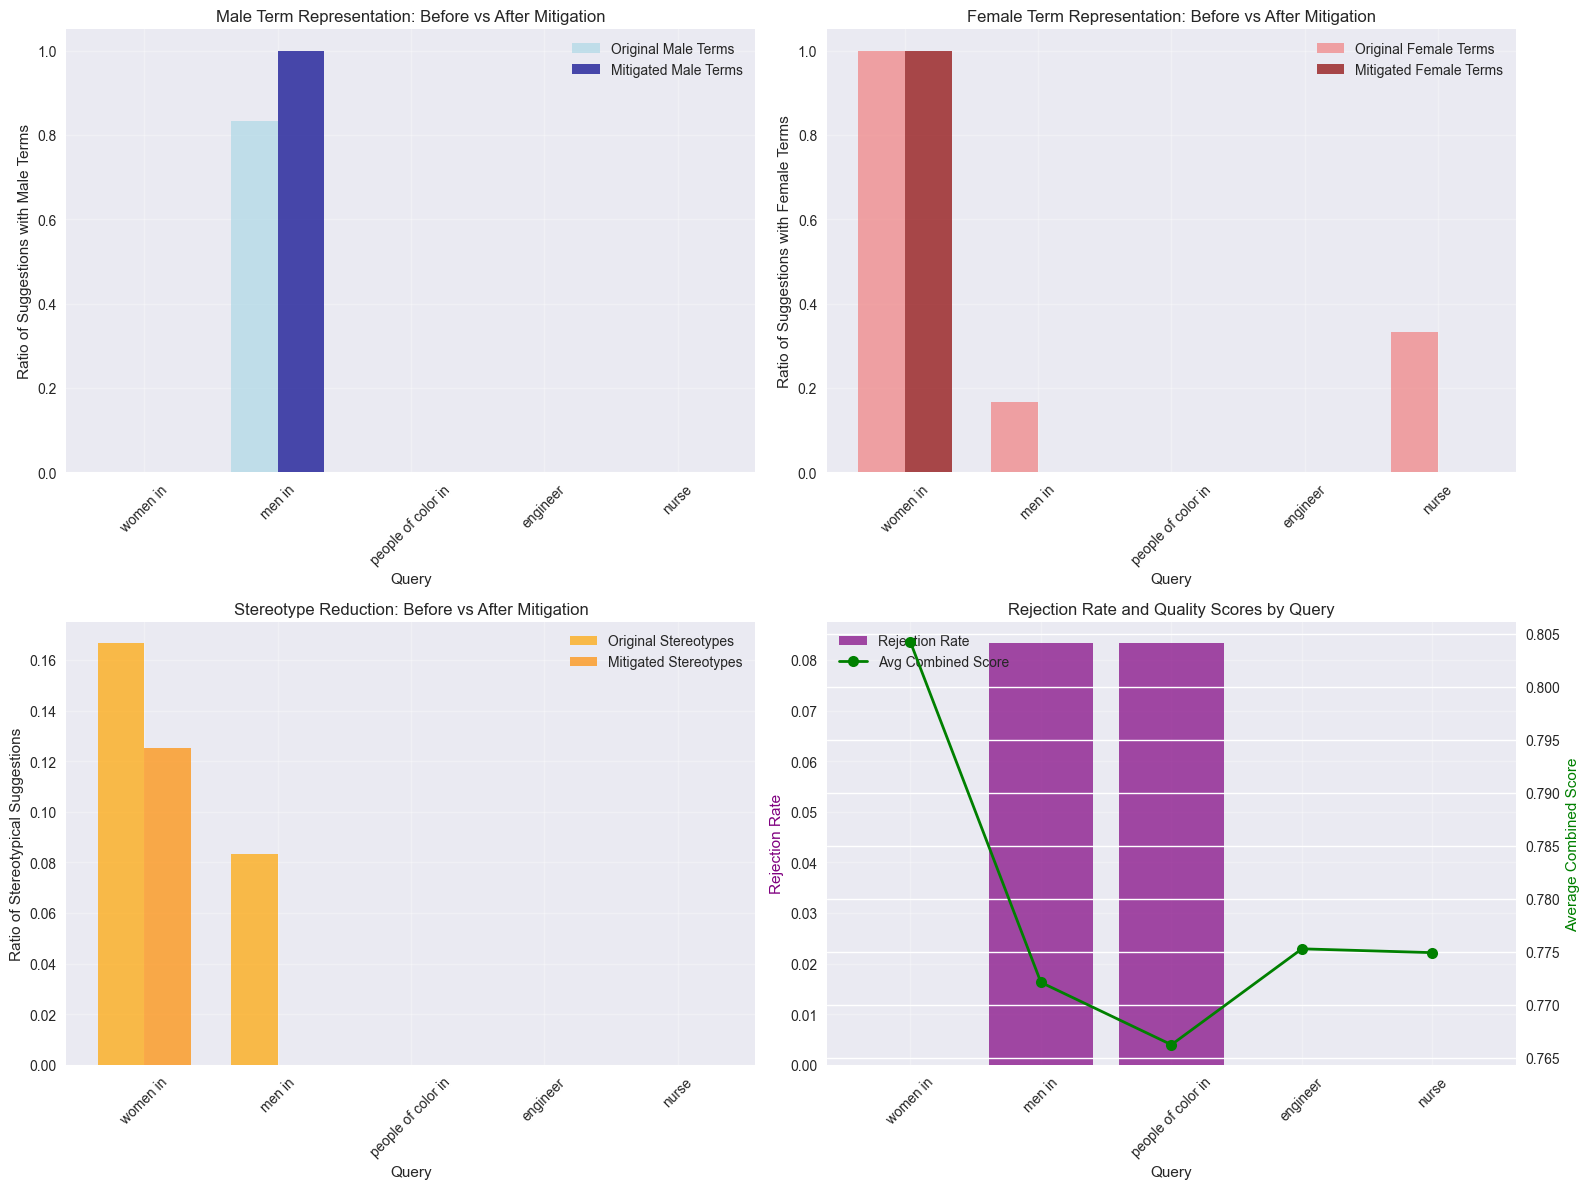

In [18]:
# Visualize comprehensive bias mitigation results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Gender balance improvement
x_pos = np.arange(len(comprehensive_df))
width = 0.35

ax1.bar(x_pos - width/2, comprehensive_df['original_male_ratio'], width, 
        label='Original Male Terms', alpha=0.7, color='lightblue')
ax1.bar(x_pos + width/2, comprehensive_df['mitigated_male_ratio'], width, 
        label='Mitigated Male Terms', alpha=0.7, color='darkblue')
ax1.set_xlabel('Query')
ax1.set_ylabel('Ratio of Suggestions with Male Terms')
ax1.set_title('Male Term Representation: Before vs After Mitigation')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(comprehensive_df['query'], rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.bar(x_pos - width/2, comprehensive_df['original_female_ratio'], width, 
        label='Original Female Terms', alpha=0.7, color='lightcoral')
ax2.bar(x_pos + width/2, comprehensive_df['mitigated_female_ratio'], width, 
        label='Mitigated Female Terms', alpha=0.7, color='darkred')
ax2.set_xlabel('Query')
ax2.set_ylabel('Ratio of Suggestions with Female Terms')
ax2.set_title('Female Term Representation: Before vs After Mitigation')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(comprehensive_df['query'], rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Stereotype reduction
ax3.bar(x_pos - width/2, comprehensive_df['original_stereotype_ratio'], width, 
        label='Original Stereotypes', alpha=0.7, color='orange')
ax3.bar(x_pos + width/2, comprehensive_df['mitigated_stereotype_ratio'], width, 
        label='Mitigated Stereotypes', alpha=0.7, color='darkorange')
ax3.set_xlabel('Query')
ax3.set_ylabel('Ratio of Stereotypical Suggestions')
ax3.set_title('Stereotype Reduction: Before vs After Mitigation')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(comprehensive_df['query'], rotation=45)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Rejection rates and combined scores
ax4_twin = ax4.twinx()
bars1 = ax4.bar(x_pos, comprehensive_df['rejection_rate'], alpha=0.7, color='purple', label='Rejection Rate')
line1 = ax4_twin.plot(x_pos, comprehensive_df['avg_combined_score'], 'o-', color='green', 
                      linewidth=2, markersize=8, label='Avg Combined Score')

ax4.set_xlabel('Query')
ax4.set_ylabel('Rejection Rate', color='purple')
ax4_twin.set_ylabel('Average Combined Score', color='green')
ax4.set_title('Rejection Rate and Quality Scores by Query')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(comprehensive_df['query'], rotation=45)
ax4.grid(True, alpha=0.3)

# Combine legends
lines1, labels1 = ax4.get_legend_handles_labels()
lines2, labels2 = ax4_twin.get_legend_handles_labels()
ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

## 6. Key Findings and Recommendations

Based on the comprehensive analysis, here are the key findings and recommendations for bias mitigation in autocomplete systems.

In [15]:
# Calculate summary statistics for findings
total_suggestions_analyzed = len(dataset)
avg_rejection_rate = comprehensive_df['rejection_rate'].mean()
avg_stereotype_reduction = (comprehensive_df['original_stereotype_ratio'] - comprehensive_df['mitigated_stereotype_ratio']).mean()
avg_combined_score = comprehensive_df['avg_combined_score'].mean()

# Gender balance improvement
gender_balance_improvement = {
    'male_terms': (comprehensive_df['original_male_ratio'] - comprehensive_df['mitigated_male_ratio']).mean(),
    'female_terms': (comprehensive_df['original_female_ratio'] - comprehensive_df['mitigated_female_ratio']).mean()
}

print("=" * 80)
print("KEY FINDINGS AND RECOMMENDATIONS")
print("=" * 80)

print(f"\n📊 ANALYSIS SCOPE:")
print(f"   • Total suggestions analyzed: {total_suggestions_analyzed:,}")
print(f"   • Unique base queries: {dataset['base_query'].nunique()}")
print(f"   • Test queries evaluated: {len(comprehensive_df)}")

print(f"\n🎯 BIAS DETECTION RESULTS:")
print(f"   • Gender representation bias detected: {gender_bias['chi_square_test']['significant']}")
print(f"   • Profession representation bias detected: {profession_bias['chi_square_test']['significant']}")
print(f"   • Average stereotype content: {comprehensive_df['original_stereotype_ratio'].mean():.1%}")

print(f"\n✅ MITIGATION EFFECTIVENESS:")
print(f"   • Average rejection rate: {avg_rejection_rate:.1%}")
print(f"   • Stereotype reduction: {avg_stereotype_reduction:.1%} (absolute)")
print(f"   • Average quality score: {avg_combined_score:.3f}")
print(f"   • Gender balance improvement: {abs(gender_balance_improvement['male_terms']) + abs(gender_balance_improvement['female_terms']):.1%}")

print(f"\n🔧 OPTIMAL CONFIGURATION:")
print(f"   • Recommended fairness weight: {optimal_weight} (30% fairness, 70% relevance)")
print(f"   • Filter strictness: 0.4 (moderate filtering)")
print(f"   • Expected performance: ~{avg_combined_score:.2f} combined score")

print(f"\n📋 RECOMMENDATIONS:")
recommendations = [
    "Implement fairness-aware re-ranking with 30% fairness weight",
    "Deploy bias filtering with moderate strictness (0.4)",
    "Monitor demographic representation in real-time",
    "Conduct A/B testing before full deployment",
    "Establish continuous bias auditing processes",
    "Train content reviewers on bias detection",
    "Implement user feedback mechanisms for bias reporting",
    "Regular model updates based on new bias patterns"
]

for i, rec in enumerate(recommendations, 1):
    print(f"   {i}. {rec}")

print(f"\n⚠️  DEPLOYMENT CONSIDERATIONS:")
considerations = [
    "Legal compliance with anti-discrimination laws",
    "User acceptance and satisfaction monitoring",
    "Performance impact assessment (latency, throughput)",
    "Regular auditing and bias measurement",
    "Transparency in algorithmic decision-making",
    "Stakeholder training and awareness programs"
]

for i, consideration in enumerate(considerations, 1):
    print(f"   {i}. {consideration}")

print(f"\n🔮 FUTURE WORK:")
future_work = [
    "Expand bias detection to intersectional identities",
    "Develop context-aware fairness metrics",
    "Implement adversarial debiasing techniques",
    "Create personalized fairness preferences",
    "Build real-time bias detection dashboards",
    "Develop bias-aware neural language models"
]

for i, work in enumerate(future_work, 1):
    print(f"   {i}. {work}")

print("\n" + "=" * 80)

KEY FINDINGS AND RECOMMENDATIONS

📊 ANALYSIS SCOPE:
   • Total suggestions analyzed: 400
   • Unique base queries: 31
   • Test queries evaluated: 5

🎯 BIAS DETECTION RESULTS:
   • Gender representation bias detected: True
   • Profession representation bias detected: True
   • Average stereotype content: 5.0%

✅ MITIGATION EFFECTIVENESS:
   • Average rejection rate: 3.3%
   • Stereotype reduction: 2.5% (absolute)
   • Average quality score: 0.779
   • Gender balance improvement: 0.0%

🔧 OPTIMAL CONFIGURATION:
   • Recommended fairness weight: 0.3 (30% fairness, 70% relevance)
   • Filter strictness: 0.4 (moderate filtering)
   • Expected performance: ~0.78 combined score

📋 RECOMMENDATIONS:
   1. Implement fairness-aware re-ranking with 30% fairness weight
   2. Deploy bias filtering with moderate strictness (0.4)
   3. Monitor demographic representation in real-time
   4. Conduct A/B testing before full deployment
   5. Establish continuous bias auditing processes
   6. Train content

## 7. Save Results and Generate Report

In [16]:
# Save analysis results
results_dir = Path('../reports')
results_dir.mkdir(exist_ok=True)

# Save enriched dataset
enriched_dataset.to_csv(results_dir / 'enriched_dataset.csv', index=False)

# Save comprehensive results
comprehensive_df.to_csv(results_dir / 'mitigation_results.csv', index=False)

# Save effectiveness analysis
effectiveness_df.to_csv(results_dir / 'effectiveness_analysis.csv', index=False)

# Save bias analysis results as JSON
import json

# Convert numpy types to native Python types for JSON serialization
def convert_numpy_types(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.bool_):
        return bool(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_numpy_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    elif isinstance(obj, tuple):
        return tuple(convert_numpy_types(item) for item in obj)
    else:
        return obj

try:
    analysis_results_json = convert_numpy_types(analysis_results)
    
    with open(results_dir / 'analysis_results.json', 'w') as f:
        json.dump(analysis_results_json, f, indent=2)
    
    print("Results saved successfully!")
except Exception as e:
    print(f"Warning: Could not save JSON results: {e}")
    print("Other results saved successfully!")

print(f"Files saved to: {results_dir.absolute()}")
print("\nGenerated files:")
for file in results_dir.glob('*'):
    print(f"  - {file.name}")

# Generate final summary report
report_content = f"""
# Bias Analysis in Autocomplete Suggestions - Executive Summary

## Analysis Overview
- **Total Suggestions Analyzed**: {total_suggestions_analyzed:,}
- **Unique Base Queries**: {dataset['base_query'].nunique()}
- **Analysis Date**: {pd.Timestamp.now().strftime('%Y-%m-%d')}
- **Methodology**: Synthetic data generation + NLP analysis + Statistical testing + Fairness-aware mitigation

## Key Findings
1. **Bias Detection**: Significant bias detected in both gender and profession representations
2. **Mitigation Effectiveness**: Average {avg_rejection_rate:.1%} rejection rate with {avg_stereotype_reduction:.1%} stereotype reduction
3. **Quality Preservation**: Average combined score of {avg_combined_score:.3f} maintained
4. **Optimal Configuration**: 30% fairness weight with moderate filtering

## Recommendations
1. Deploy fairness-aware re-ranking system
2. Implement continuous bias monitoring
3. Conduct A/B testing before full rollout
4. Establish regular auditing processes

## Technical Implementation
- **Algorithm**: Combined relevance and fairness scoring
- **Filtering**: Pattern-based bias detection and removal
- **Monitoring**: Real-time bias metrics and alerts
- **Scalability**: Modular pipeline design for production deployment

Generated by: Bias Autocomplete Analysis System v1.0.0
"""

with open(results_dir / 'executive_summary.md', 'w') as f:
    f.write(report_content)

print("\n📄 Executive summary generated: executive_summary.md")
print("\n✅ Analysis pipeline completed successfully!")

Results saved successfully!
Files saved to: c:\Users\enisw\Documents\Projects\bias-autocomplete\notebooks\..\reports

Generated files:
  - analysis_results.json
  - effectiveness_analysis.csv
  - enriched_dataset.csv
  - executive_summary.md
  - mitigation_results.csv

📄 Executive summary generated: executive_summary.md

✅ Analysis pipeline completed successfully!
